## Synthetic Data for Small World Penalty

In [56]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize
from scipy.special  import zeta

from scipy.stats import zipf

N = 500

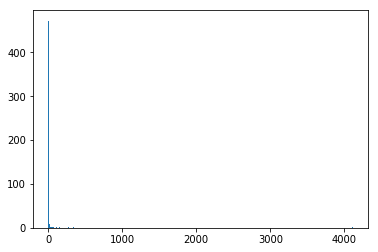

In [57]:
# 'Power law' Distribution - zipf
a = 2.0 # Shape Parameter
random_data_z = zipf.rvs(a, size=N)
plt.hist(random_data_z, N)
plt.show()

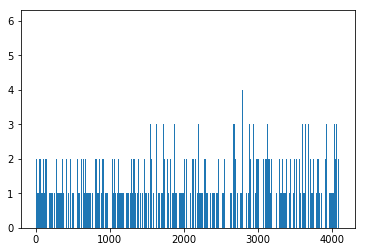

In [58]:
# Uniform Distribution
min_x, max_x = 1, random_data_z.max()

random_data_u = np.random.randint(min_x, max_x, size=N)
plt.hist(random_data_u, N)
plt.show()

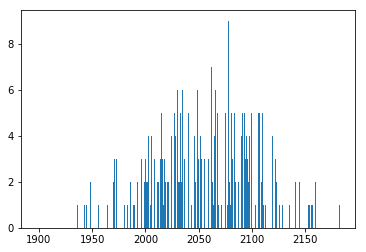

In [59]:
# Poisson Distribution
lam = int((max_x - min_x)/2)

random_data_p = np.random.poisson(lam, N)
plt.hist(random_data_p, N)
plt.show()

In [18]:
# Higher order function that takes the samples and returns a function over them that
# approximates the loss given a specific beta. That is, mle_beta(x) tells you the loss
# if the beta_empirical = x.
def mle_beta_samples(samples):
    lng = 0
    hist_cnts, hist_bins = np.histogram(samples)
    for i in range(len(hist_cnts)):
        if(hist_cnts[i] > 0): # Or stuff gets fucky real quick.
            lng += np.log(hist_cnts[i])
    
    Na = hist_cnts[0] # The zero-th element is our ath bin, which is always 1 for our purposes.
    lng = (1.0/Na)*lng
    
    # Note, we multiply by -1.0 to make this a minimization problem.
    def mle_beta(x):
        return -1.0*(-1.0*zeta(x+1, 1.0)-(x+1)*lng)
    
    return mle_beta  

In [60]:
beta_loss_z = mle_beta_samples(random_data_z)
beta_loss_u = mle_beta_samples(random_data_u)
beta_loss_p = mle_beta_samples(random_data_p)

In [61]:
result_z = minimize(beta_loss_z, 1.0, method='Nelder-Mead')
beta_emp_z = result_z['x']
print(beta_emp_z)

[5.04111328]


In [62]:
result_u = minimize(beta_loss_u, 1.0, method='Nelder-Mead')
beta_emp_u = result_u['x']
print(beta_emp_u)

[1.03720703]


In [63]:
result_p = minimize(beta_loss_p, 1.0, method='Nelder-Mead')
beta_emp_p = result_p['x']
print(beta_emp_n)

[0.35302734]


In [64]:
def d_emp(n, Na, Nn, beta):    
    def S(x, b):
        return zeta(x+1, n)/zeta(x+1, 1)
    return np.abs((Nn/Na)-S(n, beta))

def manual_demp_plot(samples, beta_emp):
    # To make life easy, setting the number of bins to equal the largest value, lots of empty
    # entries, but means I can use the index into the counts as n. That is, n = index+1 while
    # looping over the counts.
    hist_cnts, hist_bins = np.histogram(samples, bins=(samples.max()+1))
    Na  = hist_cnts[0]
    y_s = []
    for i in range(1, len(hist_cnts)):
        n  = i+1
        Nn = hist_cnts[i]
        y_s.append(d_emp(n, Na, Nn, beta_emp))

    plt.plot(range(1, len(hist_cnts)), y_s)
    plt.show()
    return y_s

## Results

Hoping that the empirical KSS values are noticeably smaller for the power law data. 

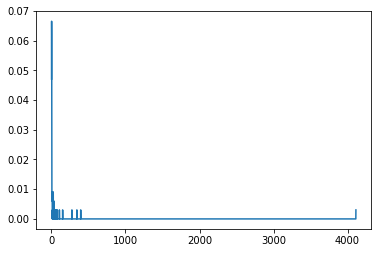

0.0665330379526744


In [65]:
y_z = manual_demp_plot(random_data_z, beta_emp_z)
print(max(y_z))

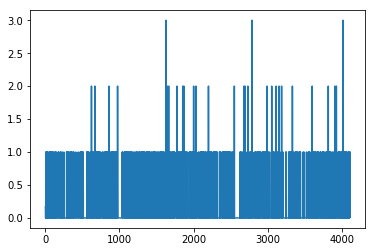

3.0


In [66]:
y_u = manual_demp_plot(random_data_u, beta_emp_u)
print(max(y_u))

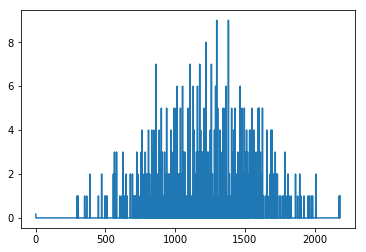

9.0


In [67]:
y_p = manual_demp_plot(random_data_p, beta_emp_p)
print(max(y_p))

To be totally sure this works, beyond just testing random dists against it, need to assume some pathological cases and see what the output is. 

However, if for a moment we assume that the KSS value found, without furthering iterations refining it, can be an indicator of 'goodness of fit', then this could be used as part of a penalty term, if there is a stage in the network architecture that can be interpreted as providing a 'network input' to further layers of the architecture.

This calculation would provide a penalty/regularization term using the KSS over said layer. 

In [ ]:
objective = C_1*loss + C_2*KSS(network_layer_output)

This adds only? one new hyperparameter to the architecture, the constant C_2, along with an introduced structural bias in the selection of which layer to interpret as a graph/network adjacency "fill in function".

## Issues?

#### What if the distribution is 'pathological' and consists of something like 'all nodes have degree 1'?

In [69]:
random_data_path = [1 for i in range(N)]
beta_loss_path = mle_beta_samples(random_data_path)
result_path = minimize(beta_loss_path, 1.0, method='Nelder-Mead')

print(result_path)

 final_simplex: (array([[1.],
       [1.]]), array([inf, inf]))
           fun: inf
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 200
           nit: 67
        status: 1
       success: False
             x: array([1.])


/home/wpower3/anaconda3/envs/swre/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/wpower3/anaconda3/envs/swre/lib/python3.5/site-packages/scipy/optimize/optimize.py:563: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


Hard to say, because of COURSE this is an impossible optimization target, this has no gradient?

#### How expensive are these calculations?

* Adjacency Matrix Computation
* Degree Distribution Calculation - TF Bin methods
* Nelder-Mead on a Large N 

#### Deeper Statistical Model?

* For what values of distribution parameters do these assumptions hold?
* Are there uniform, poisson parameters that could achieve better KSS values than a powerlaw/zipf?

Need to investigate that. Also, taking care to pick values that would be reasonably expected to occur in a pragmatic problem setting. 

## Next Steps

#### Toy Problem
Find a problem that obviously leverages some network effects over the examples, ideally one in a supervised setting, so that the introduction of this method into a real workflow can be explored.

#### Real Problem
Find an application within the news dataset problems that could perhaps be improved/attempted with the addition of this method.

* **De-Anonymization** - A 'network layer' might provide information about the connections between supposed users in a spcific domain, which could be regulularized with this method.
* **Fake News Dissemenation Modeling** - Could use this in a similar way to learn a network amounst 'actors' in the news economy to predict flow?

The use case should/has to be a situation where such an implicit network 'layer' can be added to the architecture. 